#### Импортируем все библиотеки, которые так или иначе понадобятся для решения курсовой работы

In [129]:
import numpy as np
import pandas as pd


from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, log_loss, confusion_matrix
# from sklearn.metrics import plot_roc_curve # Почему-то она не импортится.


import matplotlib.pyplot as plt
import seaborn as sns

import time

import warnings
warnings.simplefilter(action='ignore')


#### Загружаем датасеты. Есть тренировочный - train.csv - и тестовый - test.csv. Находим длину этих датасетов

In [130]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f'Длина датасета для тренировки составляет {train.shape[0]} строчек')
print(f'Длина датасета для тестирования составляет {train.shape[0]} строчек')


Длина датасета для тренировки составляет 26729 строчек
Длина датасета для тестирования составляет 26729 строчек


#### Получаем данные о датасетах

In [131]:
print('Тренировочный датасет:')
print(train.info())
print('Тестовый датасет:')
print(test.info())


Тренировочный датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26729 entries, 0 to 26728
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   AnimalID        26729 non-null  object
 1   Name            19038 non-null  object
 2   DateTime        26729 non-null  object
 3   OutcomeType     26729 non-null  object
 4   OutcomeSubtype  13117 non-null  object
 5   AnimalType      26729 non-null  object
 6   SexuponOutcome  26728 non-null  object
 7   AgeuponOutcome  26711 non-null  object
 8   Breed           26729 non-null  object
 9   Color           26729 non-null  object
dtypes: object(10)
memory usage: 2.0+ MB
None
Тестовый датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11456 entries, 0 to 11455
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              11456 non-null  int64 
 1   Name            8231 non-null  

In [132]:
# Создание таблицы сопряженности
cross_table = pd.crosstab(train['OutcomeType'], train['AnimalType'])

# Вывод таблицы сопряженности
# print(cross_table)
cross_table.head()


AnimalType,Cat,Dog
OutcomeType,,
Adoption,4272,6497
Died,147,50
Euthanasia,710,845
Return_to_owner,500,4286
Transfer,5505,3917


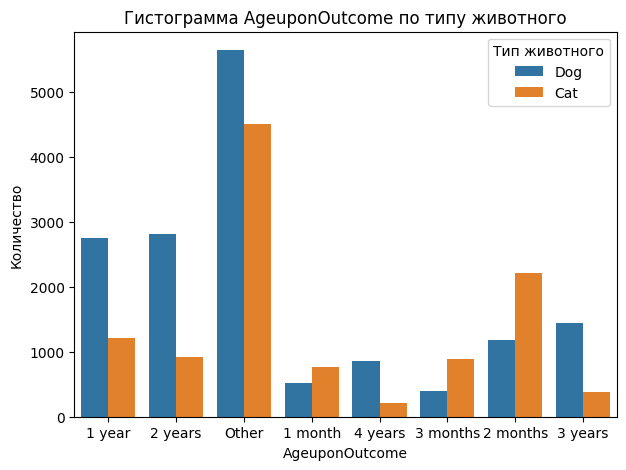

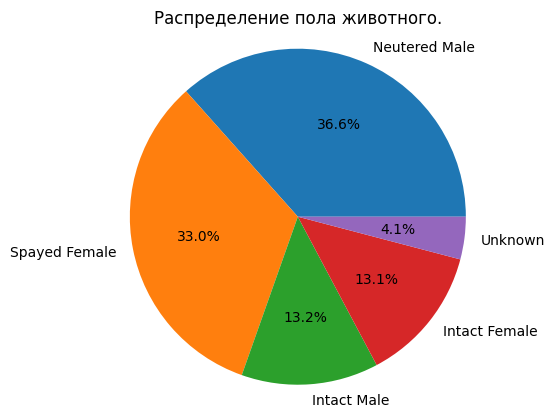

In [150]:
# Создание столбчатой диаграммы с разделением по цветам

counts = train['AgeuponOutcome'].value_counts()
threshold = 1000

other_age = train.copy()
other_age['AgeuponOutcome'] = other_age['AgeuponOutcome'].replace(counts[counts < threshold].index, 'Other')


plt.figure(figsize=(7, 5))
sns.countplot(x='AgeuponOutcome', hue='AnimalType', data=other_age)
plt.xlabel('AgeuponOutcome')
plt.ylabel('Количество')
plt.title('Гистограмма AgeuponOutcome по типу животного')
plt.legend(title='Тип животного')
plt.show()

plt.pie(train['SexuponOutcome'].value_counts(),labels=train['SexuponOutcome'].unique().tolist()[:5], autopct='%1.1f%%')
plt.axis('equal')  # Для создания круговой формы
plt.title('Распределение пола животного.')
plt.show()
# train['SexuponOutcome'].unique().tolist()


#### Изучаем первые пять строчек датасетов

In [ ]:
train.head()


,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [ ]:
test.head()


,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


#### Каждая колонка - категориальная или временный признак. Имеются следующие колонки:
1. ***AnimalID***: уникальный идентификатор животного, представленный числом или буквенно-цифровой комбинацией.
2. ***Name***: имя животного, представленное строкой. Если животное не имеет имени, то данная колонка содержит значение **NaN**.
3. ***DateTime***: дата и время, когда животное было привезено в приют. Представлены в формате даты/времени, содержащем информацию о годе, месяце, дне, часе, минуте и секунде.
4. ***OutcomeType***: результат, который произошел с животным, представленный строкой. Возможные значения: *Adoption*, *Transfer*, *Return_to_owner*, *Euthanasia*, *Died*.
5. ***OutcomeSubtype***: дополнительная информация о результате, который произошел с животным, представленный строкой. Некоторые значения этой колонки зависят от значения, указанного в колонке ***OutcomeType***. В противном случае эта колонка содержит значение **NaN**.
6. ***AnimalType***: тип животного, представленный строкой. Возможные значения: *Dog*, *Cat*.
7. ***SexuponOutcome***: информация о половой принадлежности животного и стерилизации, представленная строкой. Например, *"Neutered Male"* означает, что животное было кастрировано, а *"Intact Female"* означает, что животное не было стерилизовано.
8. ***AgeuponOutcome***: возраст животного в момент окончания пребывания в приюте. Представлен в формате числа и строки, например *"1 year"* или *"2 weeks"*.
9. ***Breed***: порода животного, представленная строкой. В некоторых случаях содержит комбинацию пород, например *"Labrador Retriever/Pointer"*.
10. ***Color***: цвет животного, представленный строкой. Может содержать информацию о нескольких цветах, например *"Brown Tabby/White"*.

#### Связи с этим выбросов быть не может.

In [ ]:
print('Тренировочный датасет:')
print(train.isna().sum())
print('Тестовый датасет:')
print(test.isna().sum())


Тренировочный датасет:
AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64
Тестовый датасет:
ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64


#### Т.к. буду решать задачу на классификацию, приютили животное или нет, то ***OutcomeSubtype*** в тренировочном датасете не нужен. Так же видно, что пустуют значения в следующих колонках:
1. ***Name***
2. ***SexuponOutcome*** 
3. ***AgeuponOutcome***
#### Проведем предобработку датасета. Сделаю следующее:
+ ***OutcomeSubtype*** - удалим
+ ***Name*** - заполним пустые значения *"Noname"*
+ ***AnimalType*** - создадим dummy столбцы
+ ***SexuponOutcome*** - Заполню модой для каждого типа животного, разделю на две колонки - ***Sex*** и ***Neuted***
+ ***AgeuponOutcome*** - переведу в числовые значения, заполню пустые значения для каждого типа животного.
+ ***OutcomeType*** - создадим новую колонку, ***Adopted***, где 1 - да, 0 - нет

In [ ]:
# заполнение пустых значений в Name на Noname
train['Name'].fillna('Noname', inplace=True)

# создадим dummy столбцы для каждого типа животного
dummy_animal_type = pd.get_dummies(train['AnimalType'], prefix='Type')
train = pd.concat([train, dummy_animal_type], axis=1)

# заполним пустое значение в SexuponOutcome на моду для этого типа животного
mode_dict = {}

for animal_type in ['Dog', 'Cat']:
    if not train[train['AnimalType'] == animal_type]['SexuponOutcome'].empty:
        mode = train[train['AnimalType'] == animal_type]['SexuponOutcome'].mode()[
            0]
        mode_dict[animal_type] = mode

for index, row in train.iterrows():
    if pd.isnull(row['SexuponOutcome']):
        animal_type = row['AnimalType']
        mode = mode_dict[animal_type]
        train.at[index, 'SexuponOutcome'] = mode

# разделим SexuponOutcome на Sex и Neuted


def process_sexuponoutcome(value):
    parts = str(value).split()
    sex = 0 if "Male" in parts else 1
    neuted = 1 if "Spayed" in parts or "Neutered" in parts else 0
    return pd.Series([sex, neuted])


train[['Sex', 'Neuted']] = train['SexuponOutcome'].apply(process_sexuponoutcome)


def calculate_age_in_months(age_str):
    '''
    Создаём новую колонку, где будет находится количество месяцев нахождения в приюте.
    Если в колонке 'AgeuponOutcome' находится:
        'day(s)', то значение делится на 30,
        'week(s)', то значение делится на 4,
        'year(s)', то значение умножается на 12.
    '''
    if pd.isna(age_str):
        return np.nan
    age, unit = age_str.split(' ')
    age = int(age)
    if 'day' in unit or 'days' in unit:
        age /= 30
    elif 'week' in unit or 'weeks' in unit:
        age /= 4
    elif 'year' in unit or 'years' in unit:
        age *= 12
    return age


train['Months'] = train['AgeuponOutcome'].apply(calculate_age_in_months)

# заполняем пропуски в 'AgeInMoths'
for animal_type in ['Dog', 'Cat']:
    median_age = train[train['AnimalType'] == animal_type]['Months'].median()
    train.loc[(train['AnimalType'] == animal_type) & (
        train['Months'].isna()), 'Months'] = median_age

# создадим колонку Adopted
train['Adopted'] = train['OutcomeType'].apply(
    lambda x: 1 if x == 'Adoption' else 0)

# удалим, теперь уже не нужные столбцы
train = train.drop(['AnimalID', 'AnimalType', 'OutcomeType',
                   'OutcomeSubtype', 'SexuponOutcome', 'AgeuponOutcome'], axis=1)

print(train.isna().sum())


Name        0
DateTime    0
Breed       0
Color       0
Type_Cat    0
Type_Dog    0
Sex         0
Neuted      0
Months      0
Adopted     0
dtype: int64


#### Теперь в датасете есть числовые значения: Sex, Neuted, Months, Adopted и dummy столбцы типа животного. Построим матрицу корреляции

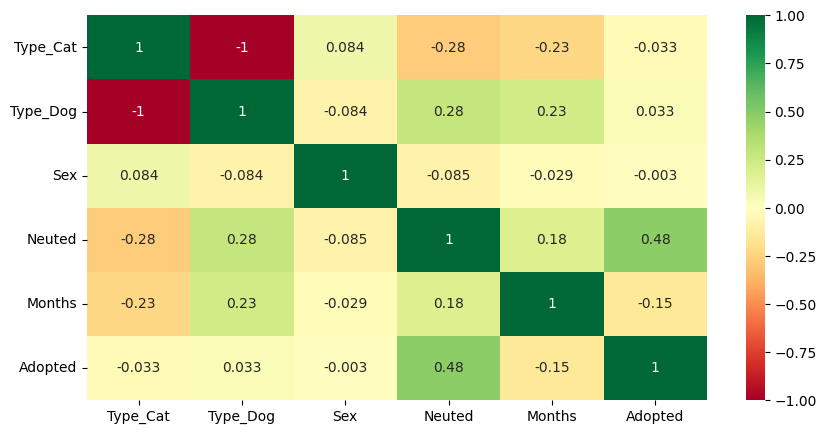

In [ ]:
# вычислим матрицу корреляции
corr_matrix = train.corr()

plt.subplots(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, cmap="RdYlGn")
plt.show()


#### предобработаем test Датасет

In [ ]:
# заполнение пустых значений в Name на Noname
test['Name'].fillna('Noname', inplace=True)

# создадим dummy столбцы для каждого типа животного
dummy_animal_type = pd.get_dummies(test['AnimalType'], prefix='Type')
test = pd.concat([test, dummy_animal_type], axis=1)

# разделим 'SexuponOutcome' на 'Sex' и 'Neuted'
test[['Sex', 'Neuted']] = test['SexuponOutcome'].apply(process_sexuponoutcome)

# переведем 'AgeuponOutcome' в месяца
test['Months'] = test['AgeuponOutcome'].apply(calculate_age_in_months)

# заполняем пропуски в 'AgeInMoths'
for animal_type in ['Dog', 'Cat']:
    median_age = test[test['AnimalType'] == animal_type]['Months'].median()
    test.loc[(test['AnimalType'] == animal_type) & (
        test['Months'].isna()), 'Months'] = median_age

# удалим, теперь уже не нужные столбцы
test = test.drop(
    ['ID', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome'], axis=1)

print(test.isna().sum())


Name        0
DateTime    0
Breed       0
Color       0
Type_Cat    0
Type_Dog    0
Sex         0
Neuted      0
Months      0
dtype: int64


In [ ]:
print(train.columns.to_list())
print(test.columns.to_list())
train.shape

['Name', 'DateTime', 'Breed', 'Color', 'Type_Cat', 'Type_Dog', 'Sex', 'Neuted', 'Months', 'Adopted']
['Name', 'DateTime', 'Breed', 'Color', 'Type_Cat', 'Type_Dog', 'Sex', 'Neuted', 'Months']


(26729, 10)

In [ ]:
# Оставляем только числовые признаки в train
numeric_features = ['Type_Cat', 'Sex', 'Neuted', 'Months']
X_train = train[numeric_features]
y_train = train['Adopted']

In [ ]:
def create_models(n_estimators: int = None, max_depth: int = None, random_state: int = None, criterion: str = None, n_splits: int = None):
    if n_estimators == None and max_depth == None and random_state == None and criterion == None and n_splits == None:
        rf = RandomForestClassifier()
        dt = DecisionTreeClassifier()
        # Создание объекта Stratified k-fold
        kfold = StratifiedKFold(n_splits=40, random_state=42, shuffle=True)
    else:
        rf = RandomForestClassifier(
            n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        dt = DecisionTreeClassifier(
            max_depth=max_depth, criterion=criterion, random_state=random_state)
        kfold = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
    return rf, dt, kfold


rf, dt, kfold = create_models()


In [ ]:
def metrics_to_dict(dt_pred, rf_pred, y_val_fold, score):
    score['dt']['accuracy']=accuracy_score(y_val_fold, dt_pred)
    score['rf']['accuracy']=accuracy_score(y_val_fold, rf_pred)

    score['dt']['f1']=f1_score(y_val_fold, dt_pred)
    score['rf']['f1']=f1_score(y_val_fold, rf_pred)

    score['dt']['roc_auc']=roc_auc_score(y_val_fold, dt_pred)
    score['rf']['roc_auc']=roc_auc_score(y_val_fold, rf_pred)

    score['dt']['precision']=precision_score(y_val_fold, dt_pred)
    score['rf']['precision']=precision_score(y_val_fold, rf_pred)

    score['dt']['recall']=recall_score(y_val_fold, dt_pred)
    score['rf']['recall']=recall_score(y_val_fold, rf_pred)


In [ ]:
def train_models(dt, rf):
    # Цикл по фолдам
    score = {
        'rf': {'accuracy': 0, 'f1': 0, 'roc_auc': 0, 'precision': 0, 'recall': 0, },
        'dt': {'accuracy': 0, 'f1': 0, 'roc_auc': 0, 'precision': 0, 'recall': 0, }
    }

    cm_dt = np.zeros((2, 2), dtype=int)
    cm_rf = np.zeros((2, 2), dtype=int)
    dt_time = 0
    rf_time = 0
    for train_idx, val_idx in kfold.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Обучение моделей на обучающей выборке
        start_time = time.time()
        dt.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        train_time = end_time-start_time
        dt_time += train_time

        start_time = time.time()
        rf.fit(X_train_fold, y_train_fold)
        end_time = time.time()
        train_time = end_time-start_time
        rf_time += train_time

        # Предсказание на валидационной выборке
        dt_pred = dt.predict(X_val_fold)
        rf_pred = rf.predict(X_val_fold)
    metrics_to_dict(dt_pred, rf_pred, y_val_fold, score)
    cm_dt=confusion_matrix(y_val_fold, dt_pred)
    cm_rf=confusion_matrix(y_val_fold, rf_pred)
    print(f'Скорость обучения RandomForest составила: {round(rf_time, 3)} секунд')
    print(f'Скорость обучения DecisionTree составила: {round(dt_time, 3)} секунд')
    return score, cm_dt, cm_rf


In [ ]:
score, cm_dt, cm_rf = train_models(dt, rf)

KeyboardInterrupt: 

In [ ]:
def plot_metrics(score, cm_dt, cm_rf):
    data1 =[]
    data2 =[]
    keys = ['Accuracy','F1 Score', 'ROC AUC', 'Precision', 'Recall']
    for key in score['rf'].keys():
        data1.append(round(score['rf'][key]*100,2))
        data2.append(round(score['dt'][key]*100,2))

    # Ширина каждого столбца
    width = 0.4

    # Положение столбцов на оси x
    x_pos = range(len(data1))

    # Создание подграфика
    fig, ax= plt.subplots(1,3, figsize=(22,5))

    # Построение гистограммы для первого набора данных
    ax[0].bar(x_pos, data1, width=width, align='edge', label='RandomForest')

    # Построение гистограммы для второго набора данных
    ax[0].bar([p + width for p in x_pos], data2, width=width, align='edge', label='DecisionTree')

    # Настройка осей и заголовка
    ax[0].set_ylabel('Значение в %')
    ax[0].set_xlabel('Метрики')
    ax[0].set_title('Гистограмма метрик для двух моделей МО')
    ax[0].set_xticks([p + width for p in x_pos])
    ax[0].set_xticklabels(keys)

    # Добавление легенды
    ax[0].legend()
    minim = round(min(min(data1), min(data2))/10, 0)*10-10
    ax[0].set_ylim(minim, None)

    mtxs = [cm_dt, cm_rf]
    word=['DecisionTree', 'RandomForest']
    for i in range(1,3):
        # Построение тепловой карты для Confusion Matrix cm_dt
        im = ax[i].imshow(mtxs[i-1], cmap='Blues')
        ax[i].set_title(f'Confusion Matrix, {word[i-1]}')
        ax[i].set_xticks([0, 1])
        ax[i].set_yticks([0, 1])
        ax[i].set_xticklabels(['Positive', 'Negative'])
        ax[i].set_yticklabels(['Positive', 'Negative'])
        ax[i].set_xlabel('Predicted')
        ax[i].set_ylabel('Actual')
        plt.colorbar(im)  # Добавление цветовой шкалы

    plt.show()

    mean_data1 = sum(data1)/len(data1)
    mean_data2 = sum(data2)/len(data2)
    print(f'Среднее значение метрик в RandomForest {mean_data1}')
    print(f'Среднее значение метрик в DecisionTree {mean_data2}')

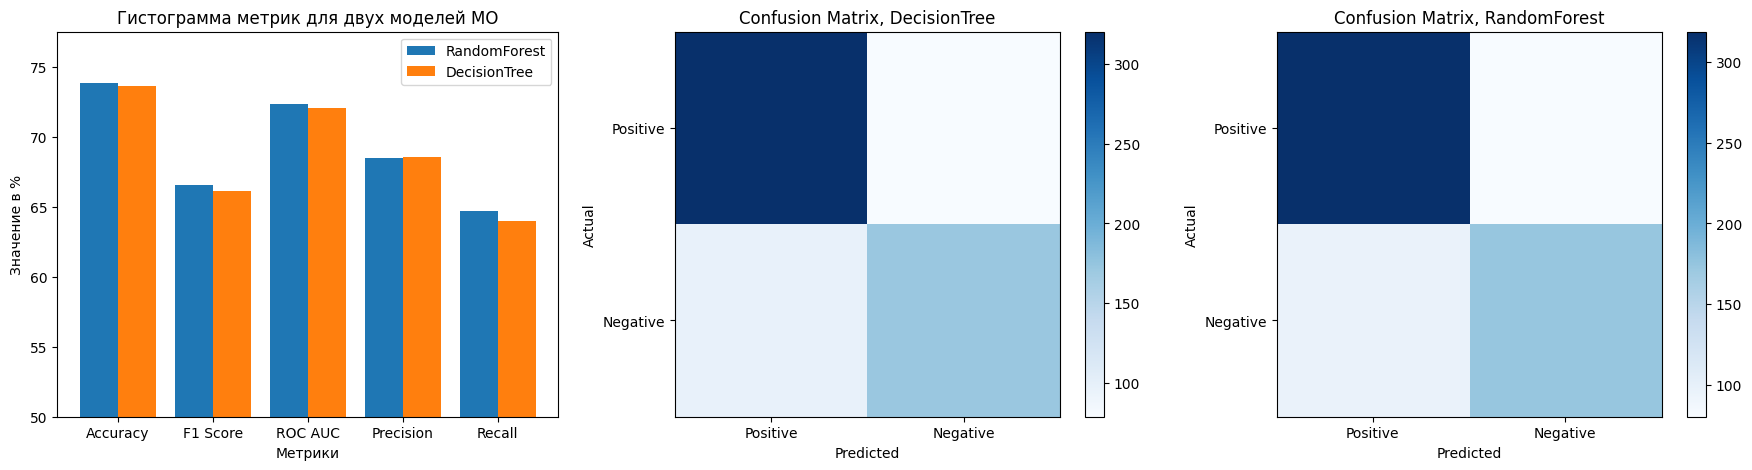

Среднее значение метрик в RandomForest 69.16799999999999
Среднее значение метрик в DecisionTree 68.868


In [ ]:
plot_metrics(score, cm_dt, cm_rf)

Скорость обучения RandomForest составила: 45.757 секунд
Скорость обучения DecisionTree составила: 0.491 секунд


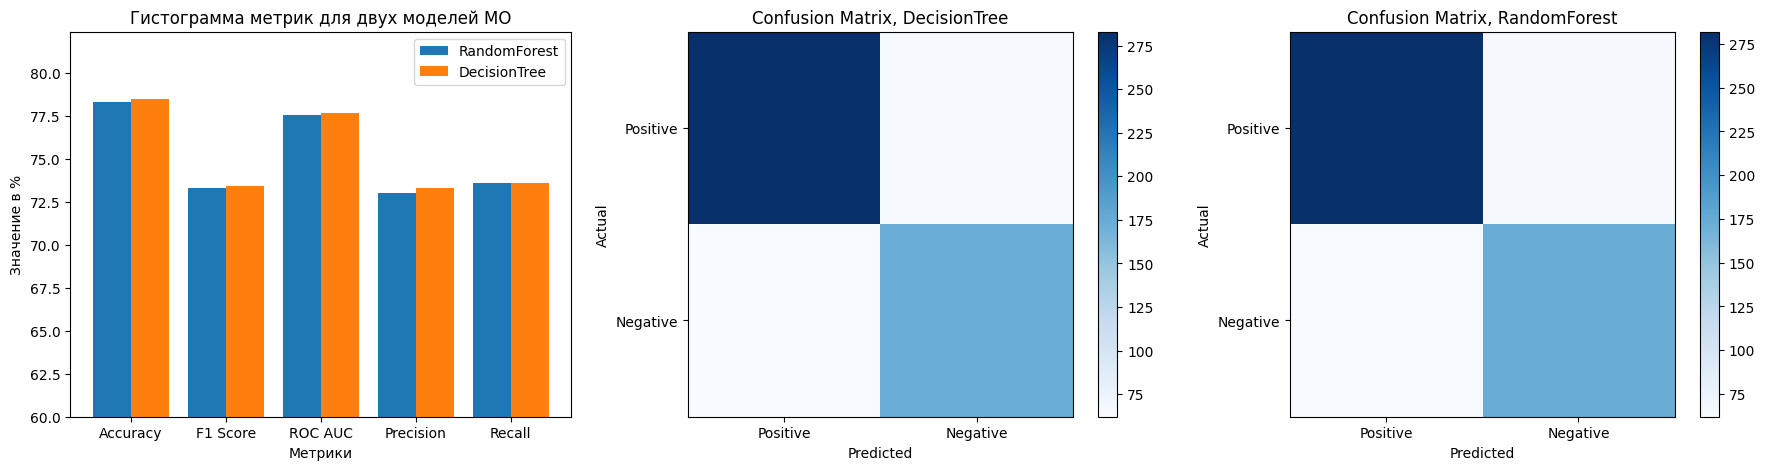

Среднее значение метрик в RandomForest 75.16
Среднее значение метрик в DecisionTree 75.316


In [ ]:
from random import randint
# state = randint(40, 100)82 
# n_splits = randint(25,50) # с помощью этих функций подбирала значения 
# print(state, n_splits)
rf, dt, kfold = create_models(150, 20, 48, 'gini', 46)
score, cm_dt, cm_rf = train_models(dt,rf)
plot_metrics(score, cm_dt, cm_rf)

In [ ]:
test_rf = test.copy()
test_dt = test.copy()


In [ ]:
X_test = test[numeric_features]

test_rf['Adopted'] = rf.predict(X_test)
test_dt['Adopted'] = dt.predict(X_test)


In [ ]:
test_rf.head()

,Name,DateTime,Breed,Color,Type_Cat,Type_Dog,Sex,Neuted,Months,Adopted
0,Summer,2015-10-12 12:15:00,Labrador Retriever Mix,Red/White,0,1,1,0,10.0,0
1,Cheyenne,2014-07-26 17:59:00,German Shepherd/Siberian Husky,Black/Tan,0,1,1,1,24.0,1
2,Gus,2016-01-13 12:20:00,Domestic Shorthair Mix,Brown Tabby,1,0,0,1,12.0,0
3,Pongo,2013-12-28 18:12:00,Collie Smooth Mix,Tricolor,0,1,0,0,4.0,0
4,Skooter,2015-09-24 17:59:00,Miniature Poodle Mix,White,0,1,0,1,24.0,0


In [ ]:
test_dt.head()


,Name,DateTime,Breed,Color,Type_Cat,Type_Dog,Sex,Neuted,Months,Adopted
0,Summer,2015-10-12 12:15:00,Labrador Retriever Mix,Red/White,0,1,1,0,10.0,0
1,Cheyenne,2014-07-26 17:59:00,German Shepherd/Siberian Husky,Black/Tan,0,1,1,1,24.0,1
2,Gus,2016-01-13 12:20:00,Domestic Shorthair Mix,Brown Tabby,1,0,0,1,12.0,0
3,Pongo,2013-12-28 18:12:00,Collie Smooth Mix,Tricolor,0,1,0,0,4.0,0
4,Skooter,2015-09-24 17:59:00,Miniature Poodle Mix,White,0,1,0,1,24.0,0


In [ ]:
test_dt.shape[0]

11456

In [ ]:
test_dt['Adopted'].sum()

4513

In [ ]:
test_rf['Adopted'].sum()

4514